# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [405]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import tensorflow_data_validation as tfdv

# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [406]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [407]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [408]:
df.head(100)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,713268,58231314,?,Female,[90-100),?,2,3,2,8,?,?,250.7,440|715,0,0,0,43,9,18,3,47918-902,None,None,No,>30
96,715086,3376278,Caucasian,Male,[10-20),?,1,5,7,1,?,?,250.11,?|?,0,0,0,51,1,4,0,68071-1701,None,None,Ch,NO
97,792402,83775519,Caucasian,Female,[80-90),?,2,1,4,2,?,?,410,424|414,0,0,0,25,7,10,1,68071-1701,None,None,No,NO
98,796152,23043240,Caucasian,Female,[50-60),?,2,1,4,2,?,?,414,424|424,0,0,0,32,9,11,3,47918-902,None,None,No,<30


## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response:??

In [409]:
# The data set is at the line level. The number of lines in the data frame (143424) is greater than the number of 
# unique encounter IDs (101766)
# Besides the encounter_id and patient_nbr fields, we could also potentially aggregate on the primary diagnosis code 
# since that is a potential correlation that might be simpler to capture while also being effective.


In [410]:
len(df)

143424

In [411]:
len(df['encounter_id'].unique())

101766

In [412]:
len(df['patient_nbr'].unique())

71518

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: ??

In [413]:
pd.DataFrame({'columns': df.columns, 
                        'percent_null': df.isnull().sum() * 100 / len(df), 
                        'percent_zero': df.isin([0]).sum() * 100 / len(df),
                        'Unknown_?': df.isin(['?']).sum() * 100 / len(df),
                        'Invalid': df.isin(['Unknown/Invalid', 'None']).sum() * 100 / len(df)
            } )

,columns,percent_null,percent_zero,Unknown_?,Invalid
encounter_id,encounter_id,0.00000,0.000000,0.000000,0.000000
patient_nbr,patient_nbr,0.00000,0.000000,0.000000,0.000000
race,race,0.00000,0.000000,2.307145,0.000000
gender,gender,0.00000,0.000000,0.000000,0.003486
age,age,0.00000,0.000000,0.000000,0.000000
weight,weight,0.00000,0.000000,97.000502,0.000000
admission_type_id,admission_type_id,0.00000,0.000000,0.000000,0.000000
discharge_disposition_id,discharge_disposition_id,0.00000,0.000000,0.000000,0.000000
admission_source_id,admission_source_id,0.00000,0.000000,0.000000,0.000000
time_in_hospital,time_in_hospital,0.00000,0.000000,0.000000,0.000000


In [414]:
np.isnan(df['time_in_hospital']).sum()

0

In [415]:
# The high '0' values for number_outpatient, number_inpatient and number_emergency is understandable since 
# they are categorical fields and not numeric, so we will leave them as-is.

# The 'weight', 'payer_code' and 'medical_specialty' fields have very high '?' values, so let us remove them from the frame
# The 'max_glu_serum' and 'A1Cresult' fields have high 'None', so let us remove them from the frame 

# There are 5 entries in the 'gender' field that has 'Unknown/Invalid', so let us remove those rows

In [416]:
df.pop('weight')
df.pop('payer_code')
df.pop('medical_specialty')
df.pop('max_glu_serum')
df.pop('A1Cresult')

invalid_indices = df[df['gender'].str.contains("Invalid")].index
df.drop(invalid_indices, inplace=True)
df['gender'].unique()


array(['Female', 'Male'], dtype=object)

In [417]:
df['change'].unique()

array(['No', 'Ch'], dtype=object)

In [418]:
len(df)

143419

In [419]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,250.83,?|?,0,0,0,41,1,1,0,NaN,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,276,250.01|255,0,0,0,59,9,18,0,68071-1701,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,648,250|V27,2,1,0,11,6,13,5,0378-1110,No,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,8,250.43|403,0,0,0,44,7,16,1,68071-1701,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,0049-4110,Ch,NO


In [420]:
# This is only a first cut to plot histograms and to analyze the data. The final numeric and categorical features
# to be input to the regression model will be derived later on
numeric_feature_list = ['encounter_id', 'patient_nbr', 'admission_type_id', 'time_in_hospital', 
                          'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']
categorical_feature_list = ['race', 'gender', 'age','admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
                            'primary_diagnosis_code', 'other_diagnosis_codes',
                            'number_outpatient', 'number_inpatient', 'number_emergency', 'ndc_code', 
                            'change', 'readmitted']

In [421]:
df[numeric_feature_list].describe()

,encounter_id,patient_nbr,admission_type_id,time_in_hospital,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,1.434190e+05,1.434190e+05,143419.000000,143419.000000,143419.000000,143419.000000,143419.000000,143419.000000
mean,1.674283e+08,5.493508e+07,2.027702,4.490214,43.256096,7.424477,16.775978,1.348964
std,1.019054e+08,3.857859e+07,1.427598,2.999648,19.657050,1.924843,8.397191,1.719078
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.829596e+07,2.357219e+07,1.000000,2.000000,32.000000,6.000000,11.000000,0.000000
50%,1.547637e+08,4.630755e+07,1.000000,4.000000,44.000000,8.000000,15.000000,1.000000
75%,2.320894e+08,8.823582e+07,3.000000,6.000000,57.000000,9.000000,21.000000,2.000000
max,4.438672e+08,1.895026e+08,8.000000,14.000000,132.000000,16.000000,81.000000,6.000000


In [422]:
# 'number_diagnosis' is manifesting a high standard deviation of ~20, so perhaps we should eliminate that field 
# from the model. But keeping it for now.


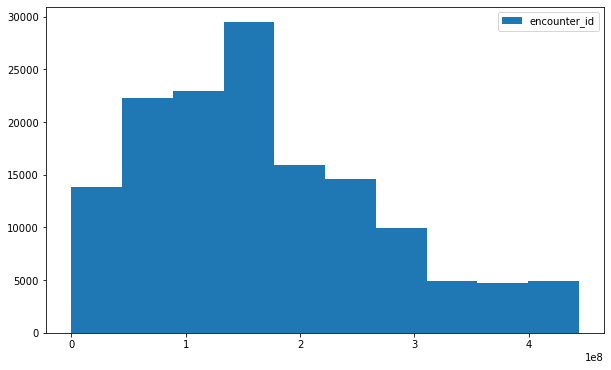

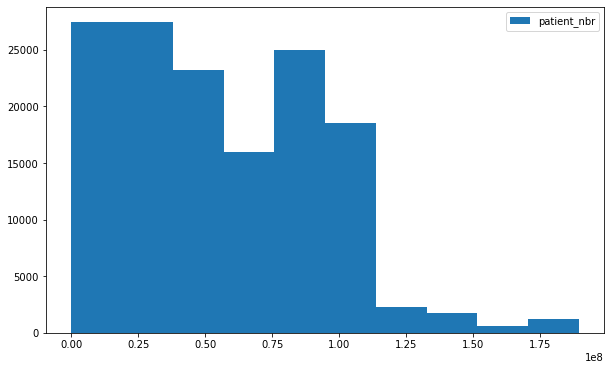

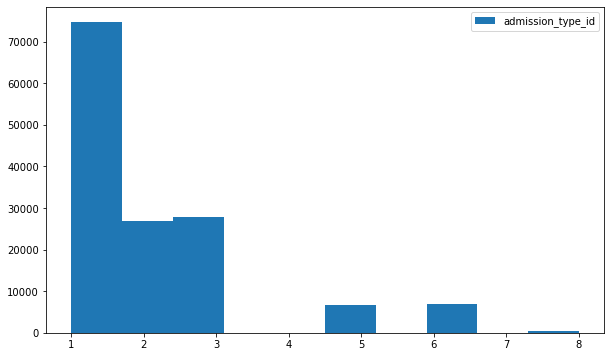

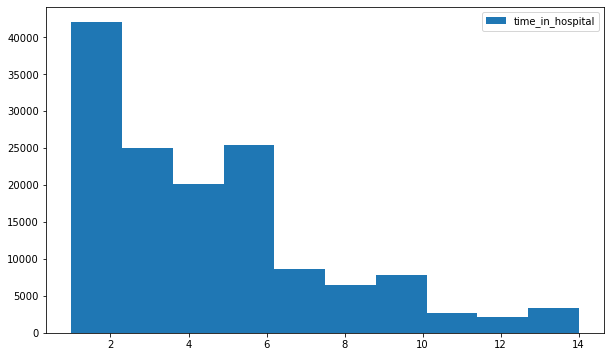

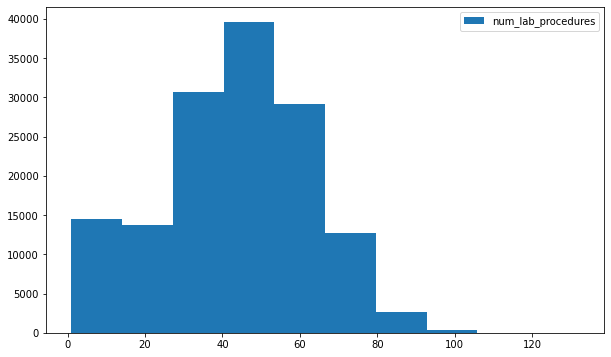

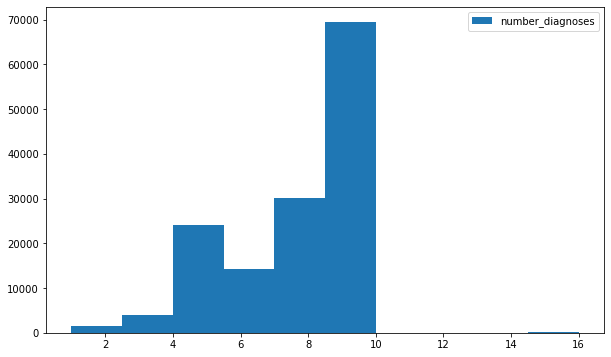

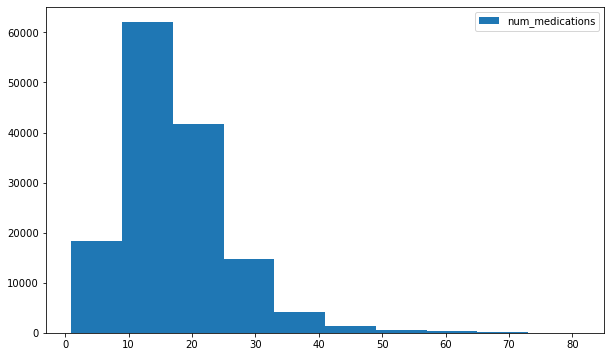

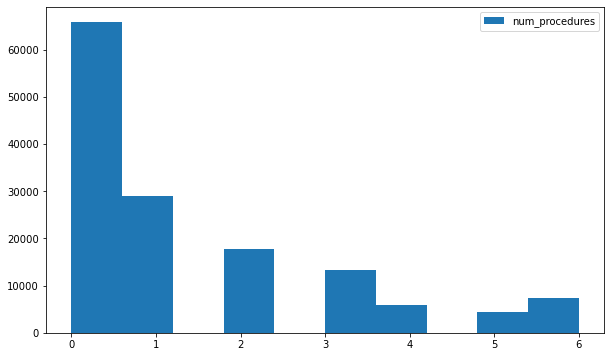

In [423]:
# Plot histograms of numeric features
for i in numeric_feature_list:
    plt.figure(figsize=(10,6))
    plt.hist(df[i],label=i)
    plt.legend()
    plt.show()

In [424]:
# From the above histograms, the 'num_lab_procedures' and 'num_medication' fields exhibit a normal-like distribution
# From the SNS plots (a few cells down below), "age" is also normally distributed

In [425]:
# Show cardinality of the categorical features 
pd.DataFrame({'columns': df[categorical_feature_list].columns, 
               'cardinality': df[categorical_feature_list].nunique() } )
# Diagnosis codes have high cardinality. Also, the 'other_diagnostic_codes' fields has a '|' separator 
# that is not parsed yet.

,columns,cardinality
race,race,6
gender,gender,2
age,age,10
admission_type_id,admission_type_id,8
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
primary_diagnosis_code,primary_diagnosis_code,717
other_diagnosis_codes,other_diagnosis_codes,19373
number_outpatient,number_outpatient,39
number_inpatient,number_inpatient,21


In [426]:
df['gender'].unique()


array(['Female', 'Male'], dtype=object)

In [427]:
len(df[df['gender']=='Unknown/Invalid']['gender'])

0

In [428]:
len(df['gender'])

143419

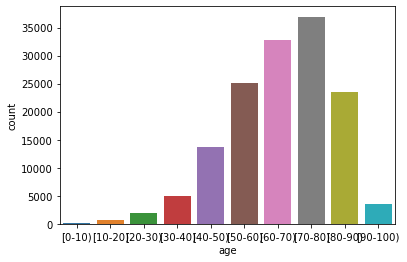

In [429]:
import seaborn as sns

df["age"]
#sns.boxplot(y=df['gender'])

sns.countplot(x="age", data=df)

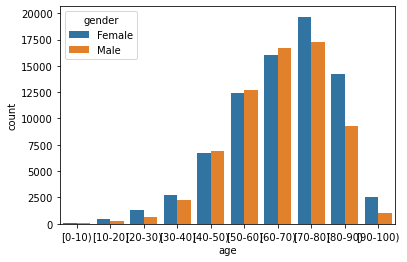

In [430]:
sns.countplot(x="age", hue="gender", data=df)

In [431]:
######NOTE: The visualization will only display in Chrome browser. ########
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [432]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [433]:
ndc_code_df

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
...,...,...,...,...,...,...,...
264,0781-5635,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug
265,64764-302,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
266,64764-304,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
267,66993-821,Pioglitazone And Glimepiride,Pioglitazone And Glimepiride,Tablet,Oral,Prasco Laboratories,Human Prescription Drug


In [434]:
from student_utils import reduce_dimension_ndc

reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [435]:
reduce_dim_df.shape

(143477, 22)

In [436]:
df.shape

(143419, 21)

In [437]:
df.nunique()

encounter_id                101763
patient_nbr                  71515
race                             6
gender                           2
age                             10
admission_type_id                8
discharge_disposition_id        26
admission_source_id             17
time_in_hospital                14
primary_diagnosis_code         717
other_diagnosis_codes        19373
number_outpatient               39
number_inpatient                21
number_emergency                33
num_lab_procedures             118
number_diagnoses                16
num_medications                 75
num_procedures                   7
ndc_code                       251
change                           2
readmitted                       3
dtype: int64

In [438]:
reduce_dim_df.nunique()

encounter_id                101763
patient_nbr                  71515
race                             6
gender                           2
age                             10
admission_type_id                8
discharge_disposition_id        26
admission_source_id             17
time_in_hospital                14
primary_diagnosis_code         717
other_diagnosis_codes        19373
number_outpatient               39
number_inpatient                21
number_emergency                33
num_lab_procedures             118
number_diagnoses                16
num_medications                 75
num_procedures                   7
ndc_code                       251
change                           2
readmitted                       3
generic_drug_name               22
dtype: int64

In [439]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [440]:
from student_utils import select_first_encounter

#print (len(df))
#print (len(first_encounter_df))
#print (df['patient_nbr'].nunique())
#print (first_encounter['patient_nbr'].nunique())
#print (first_encounter['encounter_id'].nunique())

first_encounter_df = select_first_encounter(reduce_dim_df)

In [441]:
first_encounter_df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,change,readmitted,generic_drug_name
12,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,398,427|38,0,0,0,68,8,28,2,47918-902,Ch,NO,Insulin Human
14,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,434,198|486,0,0,0,33,8,18,3,68071-1701,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,0049-4110,Ch,NO,Glipizide
15,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,250.7,403|996,0,0,0,47,9,17,2,68071-1701,No,>30,Human Insulin
6,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,414,411|250,0,0,0,31,9,16,6,47918-902,No,>30,Insulin Human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143458,443842016,183087545,Caucasian,Female,[70-80),1,1,7,9,574,574|250.02,0,0,0,50,9,33,2,0009-3449,Ch,>30,Glyburide
143460,443842022,188574944,Other,Female,[40-50),1,1,7,14,592,599|518,0,0,1,73,9,26,6,0049-0178,Ch,>30,Glipizide
143462,443842070,140199494,Other,Female,[60-70),1,1,7,2,996,585|403,1,1,1,46,9,17,6,47918-902,No,>30,Insulin Human
143464,443842340,120975314,Caucasian,Female,[80-90),1,1,7,5,292,8|304,0,0,1,76,9,22,1,47918-902,Ch,NO,Insulin Human


In [442]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71515
Number of unique encounters:71515
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [443]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [444]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [445]:
agg_drug_df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,398,427|38,0,0,0,68,8,28,2,47918-902,Ch,NO,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,434,198|486,0,0,0,33,8,18,3,68071-1701,Ch,NO,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,0049-4110,Ch,NO,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,250.7,403|996,0,0,0,47,9,17,2,68071-1701,No,>30,[Human Insulin],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,414,411|250,0,0,0,31,9,16,6,47918-902,No,>30,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54264,443841992,184875899,Other,Male,[40-50),1,1,7,13,250.8,730|731,0,0,0,51,9,13,2,0904-6328,Ch,NO,[Metformin Hydrochloride],0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
54265,443842016,183087545,Caucasian,Female,[70-80),1,1,7,9,574,574|250.02,0,0,0,50,9,33,2,0009-3449,Ch,>30,[Glyburide],0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54266,443842022,188574944,Other,Female,[40-50),1,1,7,14,592,599|518,0,0,1,73,9,26,6,0049-0178,Ch,>30,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54267,443842070,140199494,Other,Female,[60-70),1,1,7,2,996,585|403,1,1,1,46,9,17,6,47918-902,No,>30,[Insulin Human],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: ??

In [446]:
# The weight, payer_code and medical_specialty fields have very high '?' values and so they should be 
# exlcuded from our model. We have already dropped them from the dataframe during preprocessing
# Similarly A1Cresult and max_glu_serum have high 'None' values, so they have also been excluded. 
# See evidence for the above in the data processing code above

'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
#student_categorical_col_list = ['primary_diagnosis_code', 'number_emergency', 'readmitted', 'change' ] + required_demo_col_list + ndc_col_list
student_categorical_col_list = [ 'readmitted', 'admission_type_id', 'discharge_disposition_id', 
                                'admission_source_id', 'primary_diagnosis_code', #'other_diagnosis_codes', 'ndc_code',
                               ] + required_demo_col_list + ndc_col_list
#student_categorical_col_list = required_demo_col_list + ndc_col_list

#student_numerical_col_list = ['number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications', 
#                               'num_procedures']
#student_numerical_col_list = ['number_diagnoses', 'num_medications', 'num_procedures', 'number_outpatient', 
#                              'number_inpatient', 'number_emergency', 'num_lab_procedures']
student_numerical_col_list = ['number_diagnoses', 'num_medications', 'num_procedures']
PREDICTOR_FIELD = 'time_in_hospital'

In [447]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [448]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

In [449]:
selected_features_df.head()

,patient_nbr,time_in_hospital,readmitted,admission_type_id,discharge_disposition_id,admission_source_id,primary_diagnosis_code,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,number_diagnoses,num_medications,num_procedures
0,48330783,13,NO,2,1,4,398,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,28,2
1,63555939,12,NO,3,3,4,434,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8,18,3
2,42519267,1,NO,1,1,7,197,Caucasian,Male,[40-50),0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,8,0
3,89869032,9,>30,1,1,7,250.7,AfricanAmerican,Female,[40-50),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,9,17,2
4,82637451,3,>30,2,1,2,414,Caucasian,Male,[50-60),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,9,16,6


### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [450]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [451]:
from student_utils import patient_dataset_splitter

d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [452]:
d_train[student_numerical_col_list].describe().transpose()['mean']

number_diagnoses     7.276097
num_medications     16.571973
num_procedures       1.422284
Name: mean, dtype: float64

In [453]:
#Normalize the data
def norm(x, nume_cols):
    return (x - d_train[nume_cols].describe().transpose()['mean']) / d_train[nume_cols].describe().transpose()['std']
d_train[student_numerical_col_list] = norm(d_train[student_numerical_col_list], student_numerical_col_list)
d_val[student_numerical_col_list]   = norm(d_val[student_numerical_col_list], student_numerical_col_list)
#d_test[student_numerical_col_list]  = norm(d_test[student_numerical_col_list], student_numerical_col_list)

In [454]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [455]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


In [456]:
d_test

,patient_nbr,time_in_hospital,readmitted,admission_type_id,discharge_disposition_id,admission_source_id,primary_diagnosis_code,race,gender,age,Acarbose,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,number_diagnoses,num_medications,num_procedures
0,24264432,3.0,NO,1,3,7,434,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,17,1
1,99431694,4.0,NO,1,3,6,250.8,Caucasian,Male,[70-80),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9,12,0
2,87297345,1.0,>30,1,1,7,786,Caucasian,Male,[50-60),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,13,0
3,67130091,4.0,NO,3,1,2,738,Caucasian,Male,[50-60),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,32,2
4,41464089,7.0,>30,1,6,7,428,Caucasian,Female,[70-80),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,9,25,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10849,68161518,3.0,NO,1,1,7,434,Caucasian,Female,[60-70),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9,17,2
10850,41456448,4.0,>30,1,1,7,560,Caucasian,Female,[60-70),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,14,0
10851,57846393,6.0,NO,2,3,4,599,Asian,Female,[90-100),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,9,19,0
10852,78751161,5.0,NO,1,6,7,250.82,Caucasian,Female,[50-60),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9,21,1


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     7317
2.0     9191
3.0     9740
4.0     7417
5.0     5348
6.0     3991
7.0     3123
8.0     2310
9.0     1597
10.0    1241
11.0    1008
12.0     783
13.0     663
14.0     540
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


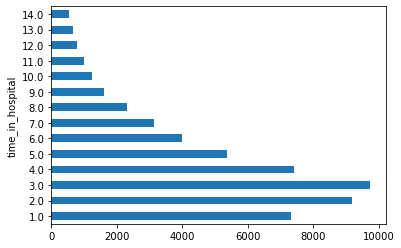

In [457]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4382
2.0     5491
3.0     5916
4.0     4458
5.0     3175
6.0     2392
7.0     1882
8.0     1389
9.0      957
10.0     724
11.0     596
12.0     477
13.0     398
14.0     324
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


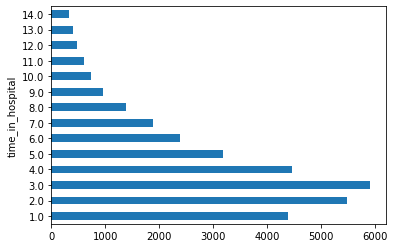

In [458]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1494
2.0     1848
3.0     1876
4.0     1525
5.0     1099
6.0      765
7.0      615
8.0      477
9.0      301
10.0     253
11.0     219
12.0     146
13.0     140
14.0      96
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


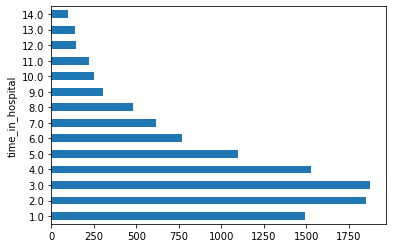

In [459]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female    28572
Male      25697
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


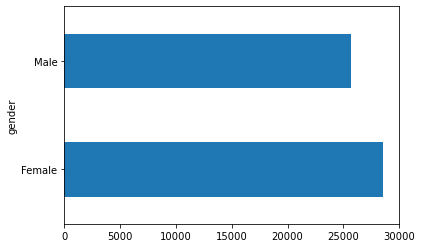

In [460]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    17180
Male      15381
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


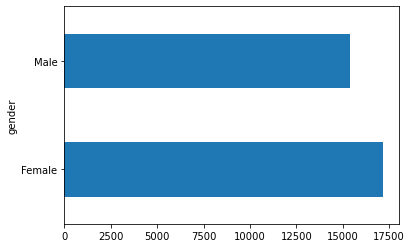

In [461]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    5716
Male      5138
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


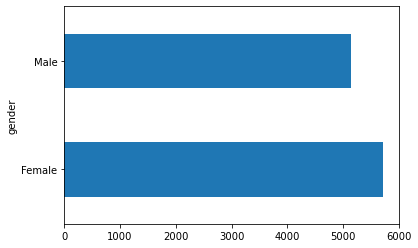

In [462]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [463]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [464]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [465]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [466]:
vocab_file_list

['./diabetes_vocab/readmitted_vocab.txt',
 './diabetes_vocab/admission_type_id_vocab.txt',
 './diabetes_vocab/discharge_disposition_id_vocab.txt',
 './diabetes_vocab/admission_source_id_vocab.txt',
 './diabetes_vocab/primary_diagnosis_code_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Human_Insulin_vocab.txt',
 './diabetes_vocab/Insulin_Human_vocab.txt',
 './diabetes_vocab/Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Mig

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [467]:
from student_utils import create_tf_categorical_feature_cols
"""
student_categorical_col_list = ['race', 'gender', 'age' ]
df = pd.read_csv('./data/final_project_dataset.csv')
batch_size = 128
PREDICTOR ='time_in_hospital'
diabetes_train_ds = df_to_dataset(df[ student_categorical_col_list + [PREDICTOR] ], PREDICTOR, batch_size=batch_size)
diabetes_batch = next(iter(diabetes_train_ds))[0]
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)
"""
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.


readmitted ./diabetes_vocab/readmitted_vocab.txt
INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.


admission_type_id ./diabetes_vocab/admission_type_id_vocab.txt
INFO:tensorflow:vocabulary_size = 26 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 26 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.


discharge_disposition_id ./diabetes_vocab/discharge_disposition_id_vocab.txt
INFO:tensorflow:vocabulary_size = 18 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.


INFO:tensorflow:vocabulary_size = 18 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.


admission_source_id ./diabetes_vocab/admission_source_id_vocab.txt
INFO:tensorflow:vocabulary_size = 602 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.


INFO:tensorflow:vocabulary_size = 602 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.


primary_diagnosis_code ./diabetes_vocab/primary_diagnosis_code_vocab.txt
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.


INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.


race ./diabetes_vocab/race_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.


gender ./diabetes_vocab/gender_vocab.txt
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.


INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.


age ./diabetes_vocab/age_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.


Acarbose ./diabetes_vocab/Acarbose_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glimepiride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glimepiride_vocab.txt.


Glimepiride ./diabetes_vocab/Glimepiride_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Glipizide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glipizide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_vocab.txt.


Glipizide ./diabetes_vocab/Glipizide_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Glipizide_And_Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glipizide_And_Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt.


Glipizide_And_Metformin_Hcl ./diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Glipizide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glipizide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt.


Glipizide_And_Metformin_Hydrochloride ./diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Glyburide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glyburide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_vocab.txt.


Glyburide ./diabetes_vocab/Glyburide_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Glyburide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glyburide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt.


Glyburide_And_Metformin_Hydrochloride ./diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Glyburide-metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glyburide-metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt.


Glyburide-metformin_Hydrochloride ./diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Human_Insulin is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Human_Insulin_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Human_Insulin is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Human_Insulin_vocab.txt.


Human_Insulin ./diabetes_vocab/Human_Insulin_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Insulin_Human is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Insulin_Human_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Insulin_Human is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Insulin_Human_vocab.txt.


Insulin_Human ./diabetes_vocab/Insulin_Human_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hcl_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hcl_vocab.txt.


Metformin_Hcl ./diabetes_vocab/Metformin_Hcl_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hydrochloride_vocab.txt.


Metformin_Hydrochloride ./diabetes_vocab/Metformin_Hydrochloride_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Miglitol is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Miglitol_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Miglitol is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Miglitol_vocab.txt.


Miglitol ./diabetes_vocab/Miglitol_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Nateglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Nateglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Nateglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Nateglinide_vocab.txt.


Nateglinide ./diabetes_vocab/Nateglinide_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Pioglitazone is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Pioglitazone is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_vocab.txt.


Pioglitazone ./diabetes_vocab/Pioglitazone_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Pioglitazone_Hydrochloride_And_Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_Hydrochloride_And_Glimepiride_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Pioglitazone_Hydrochloride_And_Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_Hydrochloride_And_Glimepiride_vocab.txt.


Pioglitazone_Hydrochloride_And_Glimepiride ./diabetes_vocab/Pioglitazone_Hydrochloride_And_Glimepiride_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Repaglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Repaglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Repaglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Repaglinide_vocab.txt.


Repaglinide ./diabetes_vocab/Repaglinide_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Rosiglitazone_Maleate is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Rosiglitazone_Maleate_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Rosiglitazone_Maleate is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Rosiglitazone_Maleate_vocab.txt.


Rosiglitazone_Maleate ./diabetes_vocab/Rosiglitazone_Maleate_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Tolazamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolazamide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Tolazamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolazamide_vocab.txt.


Tolazamide ./diabetes_vocab/Tolazamide_vocab.txt
INFO:tensorflow:vocabulary_size = 3 in Tolbutamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolbutamide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Tolbutamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolbutamide_vocab.txt.


Tolbutamide ./diabetes_vocab/Tolbutamide_vocab.txt


In [468]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='readmitted', vocabulary_file='./diabetes_vocab/readmitted_vocab.txt', vocabulary_size=4, num_oov_buckets=1, dtype=tf.string, default_value=-1))

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



tf.Tensor(
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [469]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [470]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    #mean =0
    #std = 1
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [471]:
#print (student_numerical_col_list)
#print (student_numerical_col_list[0])
#d_train[student_numerical_col_list[0]]
"""
student_numerical_col_list = ['num_lab_procedures', 'num_medications', 'number_diagnoses']
df = pd.read_csv('./data/final_project_dataset.csv')
batch_size = 128
PREDICTOR ='time_in_hospital'
diabetes_train_ds = df_to_dataset(df[ student_numerical_col_list + [PREDICTOR] ], PREDICTOR, batch_size=batch_size)
diabetes_batch = next(iter(diabetes_train_ds))[0]
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, df[student_numerical_col_list])
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)
"""
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [472]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='number_diagnoses', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7fb8c51359e0>, mean=-2.0687156828739134e-16, std=1.0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



tf.Tensor(
[[ 0.8613502 ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [-1.1372547 ]
 [-0.6376035 ]
 [ 0.36169893]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [-0.6376035 ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [ 0.36169893]
 [-0.1379523 ]
 [-1.1372547 ]
 [ 0.8613502 ]
 [-0.1379523 ]
 [-1.636906  ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [-0.6376035 ]
 [-1.1372547 ]
 [-2.136557  ]
 [-2.6362085 ]
 [ 0.36169893]
 [ 0.36169893]
 [-0.1379523 ]
 [ 0.36169893]
 [-0.1379523 ]
 [ 0.36169893]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [-2.6362085 ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [-1.636906  ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [ 0.36169893]
 [ 0.8613502 ]
 [ 0.36169893]
 [ 0.36169893]
 [ 0.36169893]
 [-3.1358597 ]
 [-1.1372547 ]
 [-0.1379523 ]
 [ 0.36169893]
 [ 0.36169893]
 [ 0.36169893]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [ 0.36169893]
 [-1.636906  ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [ 0.36169893]
 [-1.1372547 ]
 [ 0.8613502 ]
 [ 0.8613502 ]
 [-1.1372547 ]
 [ 0.8613502 ]

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [473]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [474]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [475]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Train for 255 steps, validate for 85 steps
Epoch 1/10
255/255 [==============================] - 11s 43ms/step - loss: 27.6626 - mse: 27.5311 - val_loss: 100.2558 - val_mse: 100.2170
Epoch 2/10
255/255 [==============================] - 8s 30ms/step - loss: 19.1998 - mse: 18.6096 - val_loss: 410.6509 - val_mse: 410.8615
Epoch 3/10
255/255 [==============================] - 7s 29ms/step - loss: 14.9225 - mse: 14.2128 - val_loss: 923.9064 - val_mse: 920.9323
Epoch 4/10
255/255 [==============================] - 7s 29ms/step - loss: 12.1363 - mse: 11.1866 - val_loss: 847.6123 - val_mse: 848.2239
Epoch 5/10
255/255 [==============================] - 7s 29ms/step - loss: 11.3936 - mse: 10.3333 - val_loss: 831.6171 - val_mse: 831.3814
Epoch 6/10
255/255 [==============================] - 7s 29ms/step - loss: 10.8255 - mse: 9.9768 - val_loss: 1047.6978 - val_mse: 1048.8491
Epoch 7/10
255/255 [==============================] - 7s 29ms/step - loss: 10.6601 - mse: 9.8167 - val_loss: 1153.0549 - 

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [476]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
#d_test[feature_list].head()


In [477]:
#print (diabetes_x_tst)
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)
print(diabetes_yhat)

tfp.distributions.Normal("sequential_6/distribution_lambda_6/Normal/", batch_shape=[10854, 1], event_shape=[], dtype=float32)


In [478]:
from student_utils import get_mean_std_from_preds

m, s = get_mean_std_from_preds(diabetes_yhat)

In [479]:
print (m)

tf.Tensor(
[[1.2239883]
 [1.2239883]
 [1.2239883]
 ...
 [1.2239883]
 [1.2239883]
 [1.2239883]], shape=(10854, 1), dtype=float32)


## Show Prediction Output 

In [480]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [481]:
prob_output_df.describe()

,pred,actual_value,pred_mean,pred_std
count,10854.000000,10854.000000,10854.000000,10854.000000
mean,27.561081,4.393588,1.223988,0.688321
std,18.061121,2.974237,0.000000,0.000000
min,-3.056073,1.000000,1.223988,0.688321
25%,15.097404,2.000000,1.223988,0.688321
50%,24.083462,4.000000,1.223988,0.688321
75%,35.548993,6.000000,1.223988,0.688321
max,201.473892,14.000000,1.223988,0.688321


In [482]:
prob_output_df

,pred,actual_value,pred_mean,pred_std
0,12.343987,3.0,1.223988,0.688321
1,35.436169,4.0,1.223988,0.688321
2,54.355946,1.0,1.223988,0.688321
3,16.276314,4.0,1.223988,0.688321
4,12.358015,7.0,1.223988,0.688321
...,...,...,...,...
10849,24.636808,3.0,1.223988,0.688321
10850,16.062744,4.0,1.223988,0.688321
10851,19.244745,6.0,1.223988,0.688321
10852,68.907043,5.0,1.223988,0.688321


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [483]:
from student_utils import get_student_binary_prediction

student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred') #change to pred_mean

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [484]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [485]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()
print ("# Match =", len(pred_test_df[(pred_test_df['score'] == pred_test_df['label_value'])]))
print ("# Mismatch =", len(pred_test_df[(pred_test_df['score'] != pred_test_df['label_value'])]))
print ("# NaNs in Prediction =", len(pred_test_df[np.isnan(pred_test_df['score'])]))

# Match = 5860
# Mismatch = 4994
# NaNs in Prediction = 0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [487]:
# AUC, F1, precision and recall
# Summary
# The model displays a precision of 0.63, recall of 0.65 and an f1-score of 0.64.
# In order to get the model working at this level, I used a classification threshold of 30 days
# on the pred values returned by the model. I also tried different combinations of numerical and
# categorical variables and arrived at a combination that seemingly works best.
# For future/further improvements, need to further cleanse the data. I have dropped several columns that had 
# large number of null/invalid values, but there are other columns (e.g., 'gender'), that has a small number
# of invalid values which I have kept as-is. Also, different loss functions can be tried, more hidden layers 
# can be added to the DNN, and the categorical features can be further permutated. Also, more numerical 
# features can be added and embedding columns can replace indicator columns.

from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values

accuracy_score(y_true, y_pred)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      6743
           1       0.39      0.37      0.38      4111

    accuracy                           0.54     10854
   macro avg       0.51      0.51      0.51     10854
weighted avg       0.53      0.54      0.54     10854



# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [488]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [3885]}


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [489]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

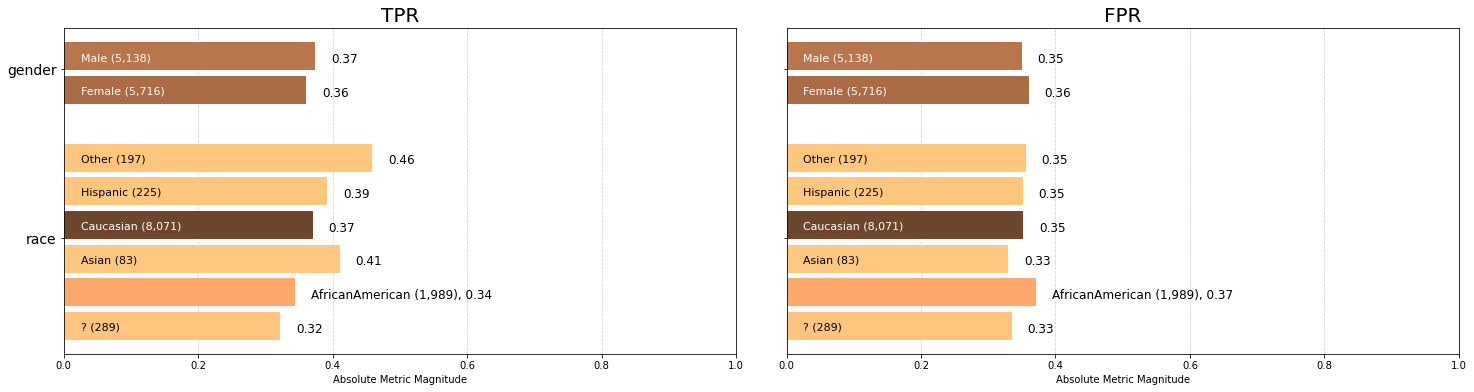

In [490]:
# Plot two metrics
#p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr'], ncols=2)

# Is there significant bias in your model for either race or gender?
# Ans: There is no significant bias at a gender level as revealed by the TPR and FPR plots
# At the race level, there seem to be a minor bias against African Americans, say, against Asians. For example,
# the TPR for African Americans is 7% points less than Asians, while the FPR is 4% points more than Asians. 
# The training data needs to be verified whether it has enough representation for African Americans.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

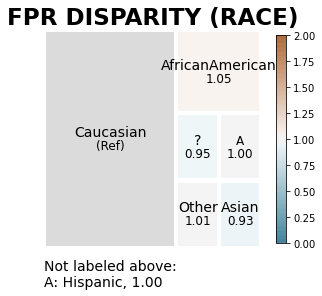

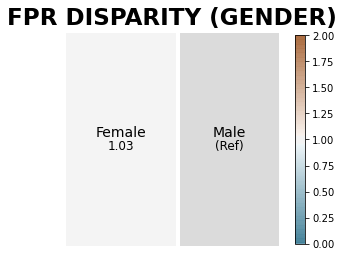

In [491]:
# Reference group fairness plot
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                   attribute_name='race')

fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                   attribute_name='gender')